# 3D parameter estimation using MCMC

This example will cover:

 - Use MCMC to infer kernel paramaters
 - Finding sample with highest log-prob from the mcmc chain
 - Visualising results of sampling
 - Making predictions

You should be setting `scale_coords=True` when there is any anisotropy. 

In [15]:
from gpvecchia import cov
from gpvecchia.vecchia import GPtideVecchia
import numpy as np
import matplotlib.pyplot as plt

import corner
import arviz as az

from gptide import stats as gpstats

from numba import njit

## Generate some data

In [16]:
####
# These are our kernel input parameters
np.random.seed(1)
noise = 0.5
η = 10
ℓ_x = 900
ℓ_y = 1800
ℓ_t = 5*24

dx = 200
dy = 200
dt = 20


@njit(cache=True)
def kernel_3d(x, xpr, params):
    """
    3D kernel
    
    Inputs:
        x: matrices input points [N,D]
        xpr: matrices output points [M,D]
        params: tuple length 4
            eta: standard deviation
            lx: x length scale
            ly: y length scale
            lt: t length scale
    Outputs:
        C: covariance matrix [N,M]
            
    """
    eta, _, _, _ = params
    
    # Build the covariance matrix
    C  = cov.matern32_1d(x[2,None], xpr[2,None], [eta, 1.0]) / eta**2 
    C *= cov.matern32_1d(x[1,None], xpr[1,None], [eta, 1.0]) / eta**2 
    C *= cov.matern32_1d(x[0,None], xpr[0,None], [eta, 1.0]) / eta**2
    C *= eta**2 
    return C


covfunc = kernel_3d

###
# Domain size parameters
N = 20

covparams = (η, ℓ_x, ℓ_y, ℓ_t)

# Input data points
xd = np.arange(0,dx*N,dx)[:,None]-dx/2
yd = np.arange(0,dy*N,dy)[:,None]-dy/2
td = np.arange(0,dt*N,dt)[:,None]-dt/2

# Make a grid
Xg, Yg, Tg = np.meshgrid(xd, yd, td)

# Vectorise grid and stack
Xv = Xg.ravel()
Yv = Yg.ravel()
Tv = Tg.ravel()
X = np.hstack([Xv[:,None], Yv[:,None], Tv[:,None]])

order_func = np.random.permutation
order_params = len(X)

GP = GPtideVecchia(X, X.copy(), noise, covfunc, covparams, scale_coords=True,
                   order_func=order_func, order_params=order_params)

# Use the .prior() method to obtain some samples
zd = GP.sample_prior(samples=1, add_noise=True)
zg = zd.reshape(Xg.shape)

In [17]:
ll = GP.log_marg_likelihood(zd)
print(f"Log marginal likelihood: {ll:.3f}")

Log marginal likelihood: -1996.307


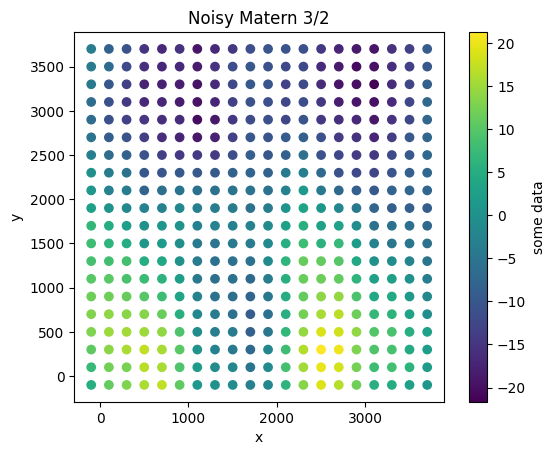

In [18]:
plt.figure()
plt.scatter(Xg[:,:,0], Yg[:,:,0], c=zg[:,:,0])
plt.ylabel('y')
plt.xlabel('x')
plt.title('Noisy Matern 3/2')
plt.colorbar(label='some data')
plt.gca().set_aspect('equal')

## Inference

We now use the `gptide.mcmc` function do the parameter estimation. This uses the `emcee.EnsembleSampler` class.


In [19]:
from gptide import mcmc
n = len(xd)
covparams

(10, 900, 1800, 120)

In [20]:
# Initial guess of the noise and covariance parameters (these can matter)

noise_prior      = gpstats.truncnorm(0.4, 0.25, 1e-15, 1)           # noise - true value 0.5
covparams_priors = [gpstats.truncnorm(8, 3, 2, 14),                   # eta   - true value 10
                    gpstats.truncnorm(600, 200, 1e-15, 1e4),           # ℓ_x - true value 900
                    gpstats.truncnorm(1400, 250, 1e-15, 1e4),           # ℓ_y - true value 1800
                    gpstats.truncnorm(7*24, 3*24, 1e-15, 1e4)]           # ℓ_t - true value 5*24

samples, log_prob, priors_out, sampler = mcmc.emcee(X, 
                                                 zd, 
                                                 covfunc, 
                                                 covparams_priors,
                                                 noise_prior,
                                                 GPclass=GPtideVecchia,
                                                 gp_kwargs={'order_func':order_func, 'order_params':order_params, 'scale_coords':True},                                                 
                                                 nwarmup=50,
                                                 niter=50,
                                                 nwalkers=30)


Running burn-in...


100%|██████████| 50/50 [09:44<00:00, 11.68s/it]


Running production...


100%|██████████| 50/50 [12:52<00:00, 15.44s/it]


An alternate inference could be performed with Metropolis Hasting sampling:

```
samples, lp_samples, accept_samples, attrs = mcmc.mh(
                                                X, 
                                                zd, 
                                                covfunc, 
                                                covparams_priors,
                                                noise_prior,
                                                nwarmup=50,
                                                niter=50)
```

No luck with MH + Vecchia for now...

## Find sample with highest log prob

In [22]:
i = np.argmax(log_prob)
MAP = samples[i, :]

print('Noise (true): {:3.2f},  Noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
print('η   (true):   {:3.2f},  η     (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
print('ℓ_x (true):   {:3.2f},  ℓ_x   (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))
print('ℓ_y (true):   {:3.2f},  ℓ_y   (mcmc): {:3.2f}'.format(covparams[2],  MAP[3])) 
print('ℓ_t (true):   {:3.2f},  ℓ_t   (mcmc): {:3.2f}'.format(covparams[3],  MAP[4]))

Noise (true): 0.50,  Noise (mcmc): 0.52
η   (true):   10.00,  η     (mcmc): 7.51
ℓ_x (true):   900.00,  ℓ_x   (mcmc): 675.78
ℓ_y (true):   1800.00,  ℓ_y   (mcmc): 1412.85
ℓ_t (true):   120.00,  ℓ_t   (mcmc): 109.42


## Posterior density plot

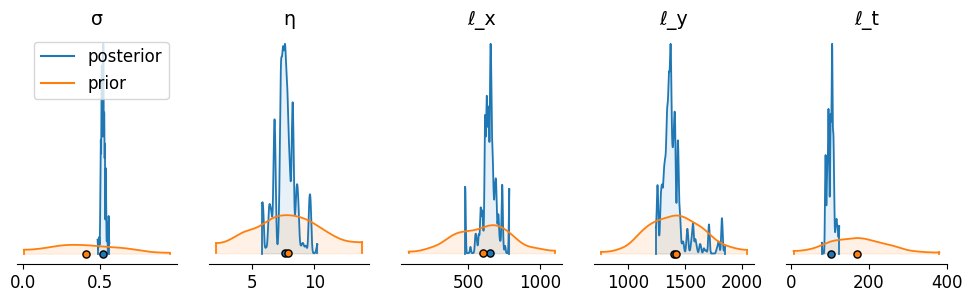

In [23]:
labels = ['σ','η','ℓ_x', 'ℓ_y', 'ℓ_t']
def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples, labels)

axs = az.plot_density(   [samples_az[labels], 
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 5),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)


## Posterior corner plot

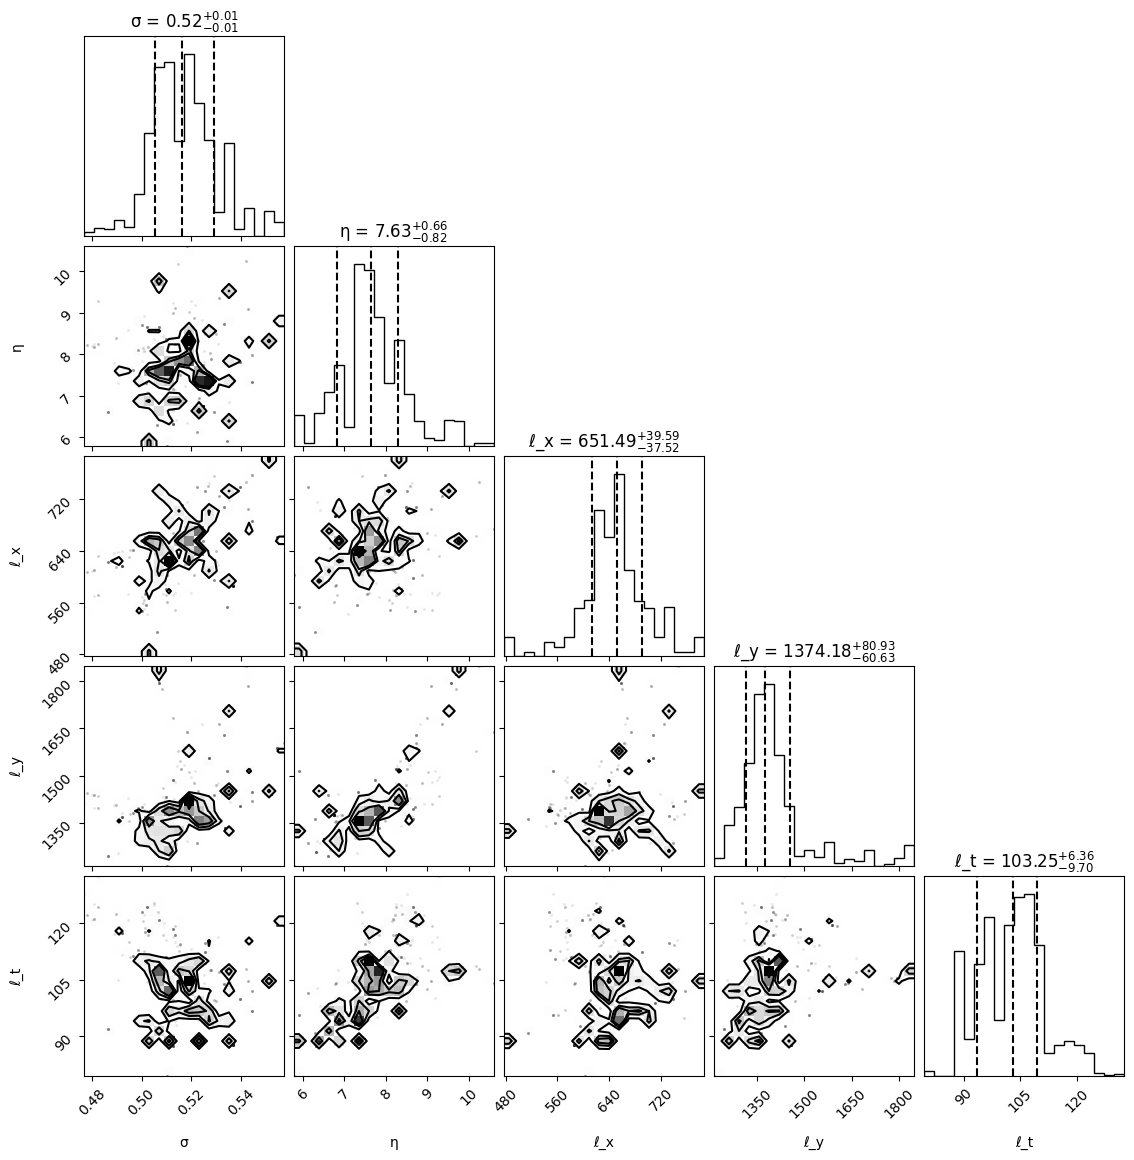

In [24]:
fig = corner.corner(samples, 
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])